## Visualize the visits overlapping a single point on the sky



In [1]:
# Some modules you're likely to want .. add whatever is needed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
# Import MAF
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils

Use the current baseline simulation included with $RUBIN_SIM_DATA_DIR

In [3]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/Users/yoachim/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db
baseline_v2.1_10yrs


And let's set up a slicer that will give us the observations that overlap a single point on the sky.

In [4]:
# Specify ra / dec of the point we want to work with on the sky - in degrees. 
# (these can be lists, if you want to work on multiple, limited points on the sky)
test_ra = 0.0
test_dec = -20.0
test_slicer = maf.UserPointsSlicer(test_ra, test_dec)

Using the 'Pass' metric will just return these columns from the database. 

In [5]:
# Set up the metric
cols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotTelPos', 'rotSkyPos', 'filter', 'night']
mymetric = maf.PassMetric(cols=cols)

In [6]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
#sqlconstraint = None   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [7]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, run_name=runName)

In [8]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_fname,
                          out_dir='test', results_db=None)
# And calculate the metric
g.run_all()

And then you can look at the `bundle.metric_values` to see what your metric calculated and how well things worked.

In [9]:
bundle.metric_values[0][0:2]

rec.array([(-21.65844749, 2611, 62829.08955707, 'r', 359.64439675, 50.00210947, -66.184957  ),
           (-21.55590219, 2870, 63088.390253  , 'r', 359.36003659, 17.85074926, -96.63808996)],
          dtype=[('fieldDec', '<f8'), ('night', '<i8'), ('observationStartMJD', '<f8'), ('filter', 'O'), ('fieldRA', '<f8'), ('rotTelPos', '<f8'), ('rotSkyPos', '<f8')])

In [10]:
# g.simData is the simulation visit data that the previous MetricBundleGroup queried from the database 
# -- so in this case, because of the "Pass" metric, it's just another way to access the same information as 'bundle.metricValues'
g.sim_data[0:2]

rec.array([(-74.71149867, 0, 60218.31679361, 'r', 350.59630738, 43.83296777, -27.43556263),
           (-75.32369112, 0, 60218.31726559, 'r', 338.77399772, 44.46824764, -38.9230366 )],
          dtype=[('fieldDec', '<f8'), ('night', '<i8'), ('observationStartMJD', '<f8'), ('filter', 'O'), ('fieldRA', '<f8'), ('rotTelPos', '<f8'), ('rotSkyPos', '<f8')])

So let's try to visualize the visits

In [11]:
visits = bundle.metric_values[0]

Text(0.5, 0, 'Distance from center of FOV (deg)')

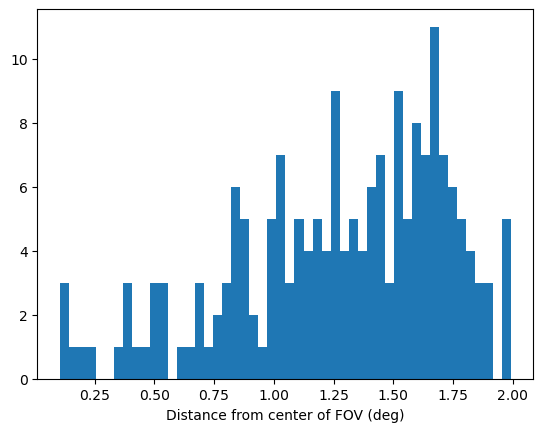

In [13]:
# How far is the center of each visit from the point on the sky? (radius is in degrees)
radius = rsUtils.angular_separation(visits['fieldRA'], visits['fieldDec'], test_ra, test_dec)
n,b,p = plt.hist(radius, bins=50)
plt.xlabel("Distance from center of FOV (deg)")

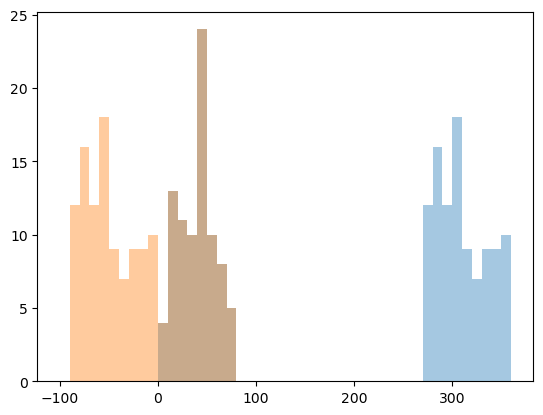

In [14]:
# what is the camera rotation angle (should run -90 to +90 but scheduler outputs map into 0-360)
rotAngle = visits['rotTelPos'] 
n,b,p = plt.hist(rotAngle, bins=np.arange(-100, 370, 10), alpha=0.4)
rotAngle = np.where(visits['rotTelPos'] > 180, visits['rotTelPos']%180-180, visits['rotTelPos'])
n,b,p = plt.hist(rotAngle, bins=b, alpha=0.4)

Text(0.5, 0, 'Rotator angle (deg)')

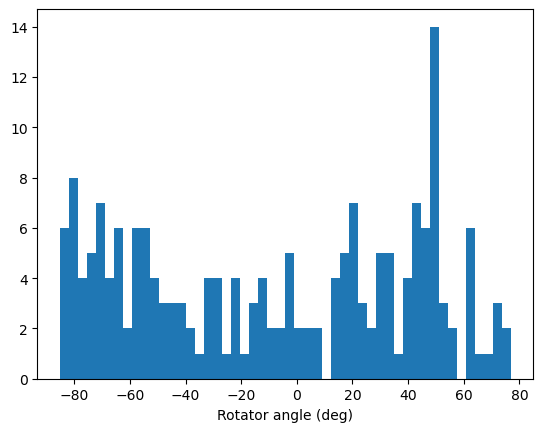

In [15]:
n,b,p = plt.hist(rotAngle, bins=50)
plt.xlabel('Rotator angle (deg)')

Text(0.5, 0, 'Rot Sky Pos (deg)')

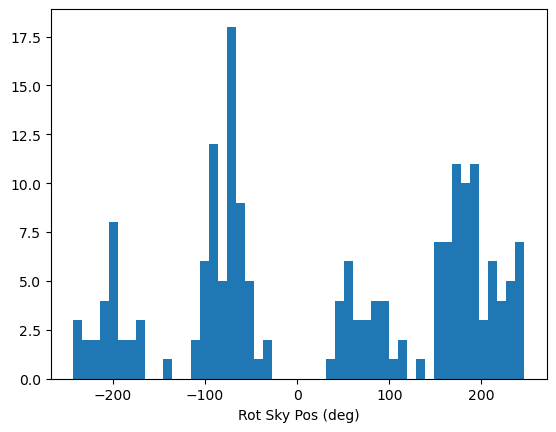

In [16]:
# Angle between "north" and the top of the FOV
n,b,p = plt.hist(visits['rotSkyPos'], bins=50)
plt.xlabel("Rot Sky Pos (deg)")

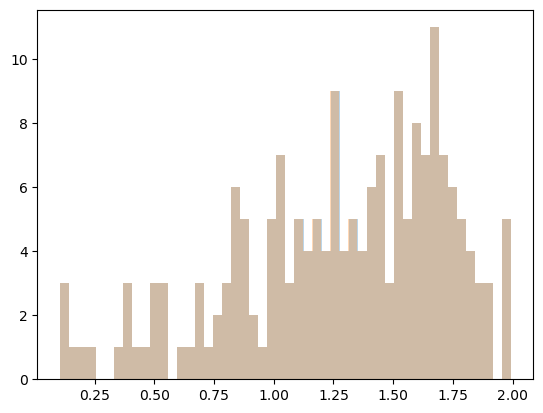

In [17]:
x, y = rsUtils.gnomonic_project_toxy(np.radians(visits['fieldRA']), 
                                      np.radians(visits['fieldDec']), 
                                      np.radians(test_ra), 
                                      np.radians(test_dec))
x = np.degrees(x)
y = np.degrees(y)
rad = np.sqrt(x**2 + y**2)
n,b,p = plt.hist(rad, bins=50, alpha=0.3)
n,b,p = plt.hist(radius, bins=50, alpha=0.3)

9


(-5.0, 5.0)

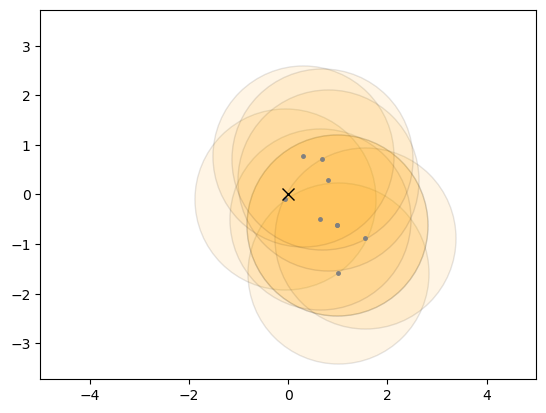

In [18]:
show = np.where((visits['filter'] == 'r') & (visits['night'] < 365*.5))
print(len(show[0]))

fig,ax = plt.subplots()
ax.axis('equal')
# These are just the center of the pointings - replace with patches
#plt.plot(x, y, 'k.')
# Might be able to do a hack?
#plt.scatter([0], [0], s=10000, 
#            #marker='o', markersize=100, linestyle=''
#            edgecolor='black', facecolor='red', alpha=0.2)
plt.scatter(x[show], y[show], s=17000, 
            #marker='o', markersize=100, linestyle=''
            edgecolor='black', facecolor='orange', alpha=0.1)
plt.plot(x[show], y[show], marker='.', markersize=5, linestyle='', color='gray')
plt.plot([0], [0], marker='x', markersize=8, linestyle='', color='k')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Let's take a slightly different approach. What if we want to look at all of the visits around this point
in the sky, at high res. 

In [21]:
# Choose a resolution
nside = 1024*4
# Find the healpixels which land within X of the test center location
hpid = np.arange(hp.nside2npix(nside))
hra, hdec = hp.pix2ang(nside, hpid, lonlat=True)
ang = rsUtils.angular_separation(hra, hdec, test_ra, test_dec)
# How big do we want to make the map? I don't know what a patch looks like
rad = 2
in_patch = np.where(ang <= rad)[0]

s = maf.HealpixSubsetSlicer(nside=nside, hpid=in_patch, use_cache=False)
m = maf.CountMetric('observationStartMJD')
constraint = 'filter == "r" and night<365/2.0'
b = maf.MetricBundle(m, s, constraint, run_name=runName)
g2 = maf.MetricBundleGroup({'0': b}, opsim_fname, 'test')
g2.run_all()

Healpix slicer using NSIDE=4096, approximate resolution 0.858872 arcminutes


{'SkyMap': 1, 'Histogram': 2}

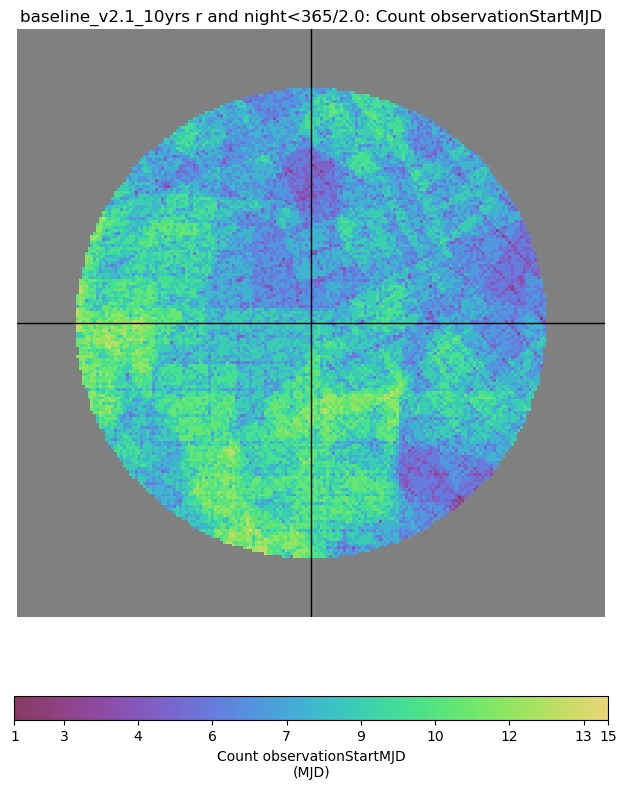

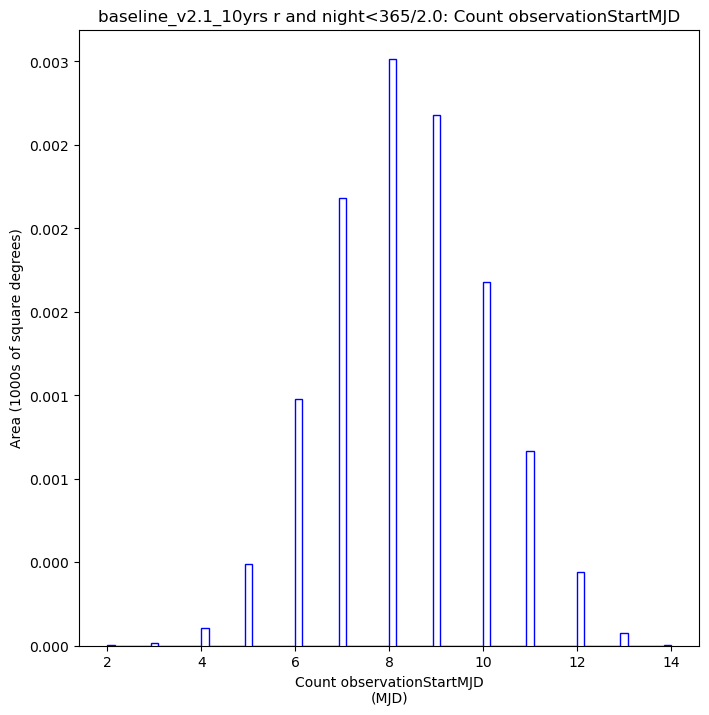

In [23]:
plotDict = {
    "visufunc": hp.gnomview,
    "rot": (test_ra, test_dec, 0),
    "xsize": 200,
    "figsize": (8, 8)
}
b.set_plot_dict(plotDict)
b.plot()

---

### Let's also look at the visits in a single night

In [24]:
# There are lots of ways to get information out of the database when you 
# just want to know "where did we look in one night" .. a simple sql query is fine
import sqlite3

cols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotTelPos', 'rotSkyPos', 'filter', 'night', 'note']
query = ' '.join(['select', ' '.join([f'{c},' for c in cols])[:-1], 'from observations where night = 200'])
print(query)
conn = sqlite3.connect(opsim_fname)
night_visits = pd.read_sql(query, conn)

conn.close()
print('nvisits total', len(night_visits))
night_visits.head()

select observationStartMJD, fieldRA, fieldDec, rotTelPos, rotSkyPos, filter, night, note from observations where night = 200
nvisits total 955


,observationStartMJD,fieldRA,fieldDec,rotTelPos,rotSkyPos,filter,night,note
0,60417.967843,120.527266,0.156208,44.384774,-129.661160,z,200,"blob_twi, iz, a"
1,60417.968291,117.590394,1.265450,43.818546,-125.110763,z,200,"blob_twi, iz, a"
2,60417.968738,115.596983,-0.635900,43.546910,-121.236381,z,200,"blob_twi, iz, a"
3,60417.969188,114.832695,2.471743,43.380019,-121.272237,z,200,"blob_twi, iz, a"
4,60417.969635,112.789267,0.547420,43.135853,-117.401444,z,200,"blob_twi, iz, a"


In [25]:
filters = night_visits['filter'].unique()
filters

array(['z', 'i', 'y', 'r'], dtype=object)

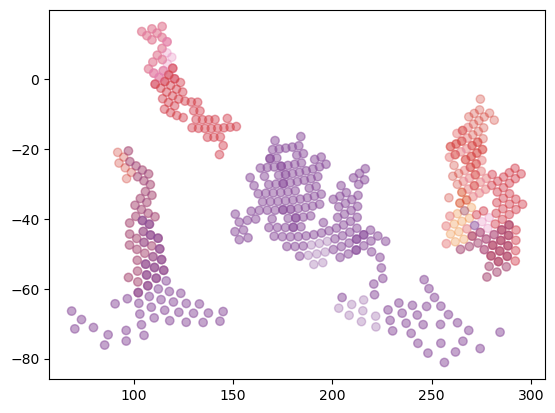

In [26]:
# locations on sky (not pretty because not projected)
filter_rgb_map = {
    "u": (74 / 256, 125 / 256, 179 / 256),
    "g": (104 / 256, 173 / 256, 87 / 256),
    "r": (238 / 256, 134 / 256, 50 / 256),
    "i": (232 / 256, 135 / 256, 189 / 256),
    "z": (209 / 256, 53 / 256, 43 / 256),
    "y": (142 / 256, 82 / 256, 159 / 256),
}

def setcolor(x):
    x['color'] = filter_rgb_map[x['filter']]
    return x

night_visits = night_visits.apply(setcolor, axis=1)

plt.scatter(night_visits['fieldRA'], night_visits['fieldDec'], c=night_visits['color'], alpha=0.3)

Text(0.5, 0, 'Rotation angle (deg)')

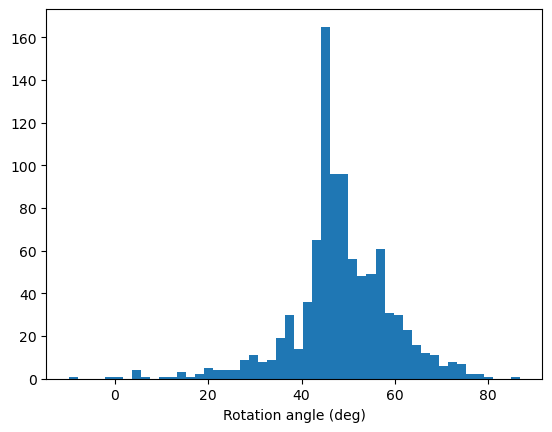

In [27]:
# put rotation angles back into -90 to 90
rotAngle = np.where(night_visits['rotTelPos'] > 180, night_visits['rotTelPos']%180-180, night_visits['rotTelPos'])
night_visits['rotAngle'] = rotAngle
n,b,p = plt.hist(rotAngle, bins=50)
plt.xlabel('Rotation angle (deg)')

Text(0.5, 0, 'Rotation Angle CHANGE (deg)')

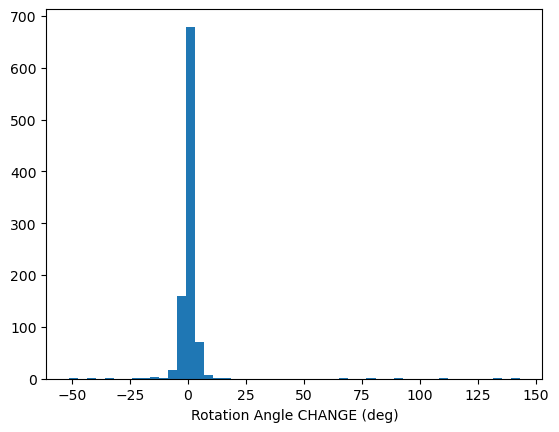

In [28]:
changes = np.diff(rotAngle)
changes = np.concatenate([[0], changes])

# Add changes for filter change
filterchange = np.where(night_visits['filter'][:-1].values != night_visits['filter'][1:].values)[0]
# Changes happen between filterchange and filterchange + 1
# replace the rotation angle changes at those points with change from previous - 0 - next
changes[filterchange+1] = (night_visits['rotAngle'][filterchange].values + 
                                                 night_visits['rotAngle'][filterchange + 1].values)

night_visits['rotChanges'] = changes
n,b,p = plt.hist(changes, bins=50)
plt.xlabel('Rotation Angle CHANGE (deg)')

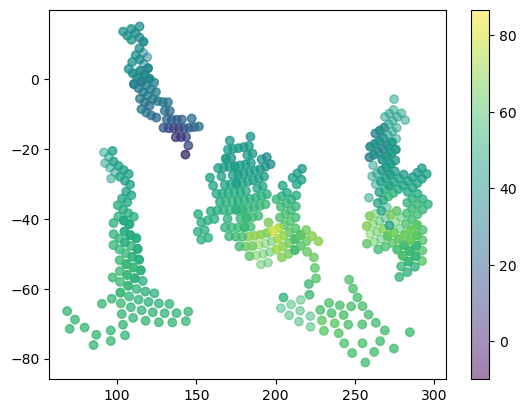

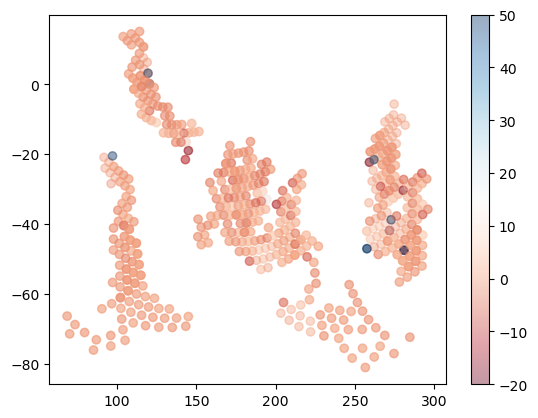

In [29]:
plt.figure()
plt.scatter(night_visits['fieldRA'], night_visits['fieldDec'], c=night_visits['rotAngle'], alpha=0.5)
plt.colorbar()
plt.figure()
plt.scatter(night_visits['fieldRA'], night_visits['fieldDec'], 
            c=night_visits['rotChanges'], alpha=0.4, cmap='RdBu', vmin=-20, vmax=50)
plt.colorbar()